### 載入依賴

In [1]:
from configparser import ConfigParser
import pandas as pd
import numpy as np

from Models.DeltaBetaFilter import DeltaBetaFilter
from Models.CutpointCalculator import CutpointCalculator
from Models.GeneFilter import GeneFilter
from Models.AucCalculator import AucCalculator
from Models.GosemsimCalculator import GosemsimCalculator
from Models.CancerStageCalculator import CancerStageCalculator

from MakeFile.FileSaver import FileSaver
from ValidateModel.ValidateData import ValidateData

### 載入設定檔

In [2]:
_configPath = "config.ini"
_config = ConfigParser()
_config.read(_configPath)

['config.ini']

### 參數

In [3]:
# 載入資料
NORMAL_NUM = 57
VALIDATE_NORMAL_NUM = 10
CHOOSE_NUM = 300
_hyperThreshold = 0.368
_hypoThreshold = -0.238
_pValueThreshold = -np.log10(0.05)

### 載入資料

In [6]:
# 原始beta資料
_betaDataDf = pd.read_csv(_config["Data"]["BETA_DATA_PATH"])
_betaDataDf.columns.values[0] = "CpG"
# 預篩選DMP資料
_dmpDataDf = pd.read_csv(_config["Data"]["DMP_DATA_PATH"]) 
_dmpDataDf.columns.values[0] = "CpG"
# 標註CpG行
_betaValidateDataDf = pd.read_csv(_config["Data"]["VALIDATE_DATA_PATH"])
_betaValidateDataDf.columns.values[0] = "CpG"

# gene相似度矩陣
_gosemsimDf = pd.read_csv(_config["Data"]["GOSEMSIM_MF_HYPER_PATH"], index_col = 0)

# 共病基因資料
with open(_config["Data"]["GROUP_COMORBIDITY_PATH"], 'r') as file:
    _lines = file.readlines()
_groupComorbidityList = [line.strip() for line in _lines]

### Dbate Analyze

In [7]:
_deltaBetaFilter = DeltaBetaFilter()
# 計算dbeta
_dbetaDf = _deltaBetaFilter.CalculateDeltaBeta(_betaDataDf, NORMAL_NUM)
# 篩選dbeta
_dbetaDf = _deltaBetaFilter.FilterDeltaBeta(_dbetaDf, _dmpDataDf, onlyPromoter = True)

find dbeta: 100%|██████████| 698386/698386 [06:21<00:00, 1830.87it/s]


In [8]:
_sortedDf = _dbetaDf.sort_values(by='dbeta')
_hyperThreshold = _sortedDf.iloc[CHOOSE_NUM]['dbeta']
_hypoThreshold = _sortedDf.iloc[len(_sortedDf) - CHOOSE_NUM]['dbeta']

# 分hyper,hypo
_hyperDf, _hypoDf = _deltaBetaFilter.DetermineDNAm(_dbetaDf, _hyperThreshold, _hypoThreshold, _pValueThreshold)

### Calculate Cutpoint

In [9]:
_validateData = ValidateData()
_cutpointCalculator = CutpointCalculator()

# 計算切點
_cutpointDf = _cutpointCalculator.CalculateCutpoint(_betaDataDf, [_hyperDf, _hypoDf], NORMAL_NUM, ["hyper", "hypo"], "CpG", "mid")

# 驗證切點
_cutpointDf, _dataNotFind = _validateData.ValidateCutpoint(_cutpointDf, _betaValidateDataDf, VALIDATE_NORMAL_NUM)

hyperDf:                 CpG     logFC   AveExpr         t       P.Value  adj.P.Val  \
67309   cg02230017  0.063267  0.090979  3.975927  1.235540e-04   0.001282   
47158   cg00336946 -0.083456  0.866664 -4.422939  2.240339e-05   0.000332   
129263  cg23546356 -0.043931  0.317531 -2.986790  3.453367e-03   0.018658   
17011   cg22294666 -0.093539  0.655921 -5.467789  2.732481e-07   0.000011   
14689   cg05399607 -0.098262  0.810363 -5.606793  1.463104e-07   0.000007   
...            ...       ...       ...       ...           ...        ...   
158004  cg21097002 -0.027940  0.816195 -2.629356  9.737559e-03   0.043040   
163248  cg06714274 -0.044659  0.492717 -2.570508  1.144611e-02   0.048967   
71690   cg01481208 -0.064406  0.702956 -3.888908  1.698991e-04   0.001655   
163424  cg18002154  0.035850  0.599287  2.568424  1.151130e-02   0.049193   
26418   cg03489712  0.065214  0.735037  5.051775  1.683965e-06   0.000045   

               B  Normal_AVG  Tumor_AVG  deltaBeta  ...  Strand  

find cutpoint: 100%|██████████| 21267/21267 [04:53<00:00, 72.51it/s]


### Comorbidity Gene Filter

In [10]:
_geneFilter = GeneFilter()
# 與共病基因交集
_groupDf = _geneFilter.IntersectData(_cutpointDf, _groupComorbidityList, "gene")

             CpG     logFC   AveExpr         t       P.Value     adj.P.Val  \
38    cg03222066  0.076385  0.620124  4.587705  1.160203e-05  1.981148e-04   
54    cg07005767  0.073449  0.617002  4.635407  9.563207e-06  1.704801e-04   
70    cg02208432  0.071516  0.563889  3.920211  1.515869e-04  1.510777e-03   
88    cg23674344  0.149531  0.167590  8.373662  1.639302e-13  2.656300e-10   
134   cg10327428  0.134389  0.320205  6.320134  5.266502e-09  5.777649e-07   
...          ...       ...       ...       ...           ...           ...   
6203  cg25092670 -0.085045  0.816500 -4.911758  3.049376e-06  7.050522e-05   
6291  cg02695726 -0.119730  0.712130 -5.943264  3.122674e-08  2.198198e-06   
6380  cg17775003 -0.095909  0.499001 -5.234965  7.634588e-07  2.442348e-05   
8624  cg27321439 -0.103939  0.662911 -5.054743  1.662736e-06  4.410299e-05   
8963  cg18598146 -0.104493  0.558461 -5.144212  1.131973e-06  3.289725e-05   

              B  Normal_AVG  Tumor_AVG  deltaBeta  ...      cgi

### Calculate Auc

In [11]:
_aucCalculator = AucCalculator()
# 計算AUC
_aucDf = _aucCalculator.CalculateAuc(_betaDataDf, _groupDf, NORMAL_NUM)

find auc: 100%|██████████| 155/155 [00:00<00:00, 1536.02it/s]


In [13]:
# 
# 計算基因相似度
# 使用R語言gosemsim計算
# 

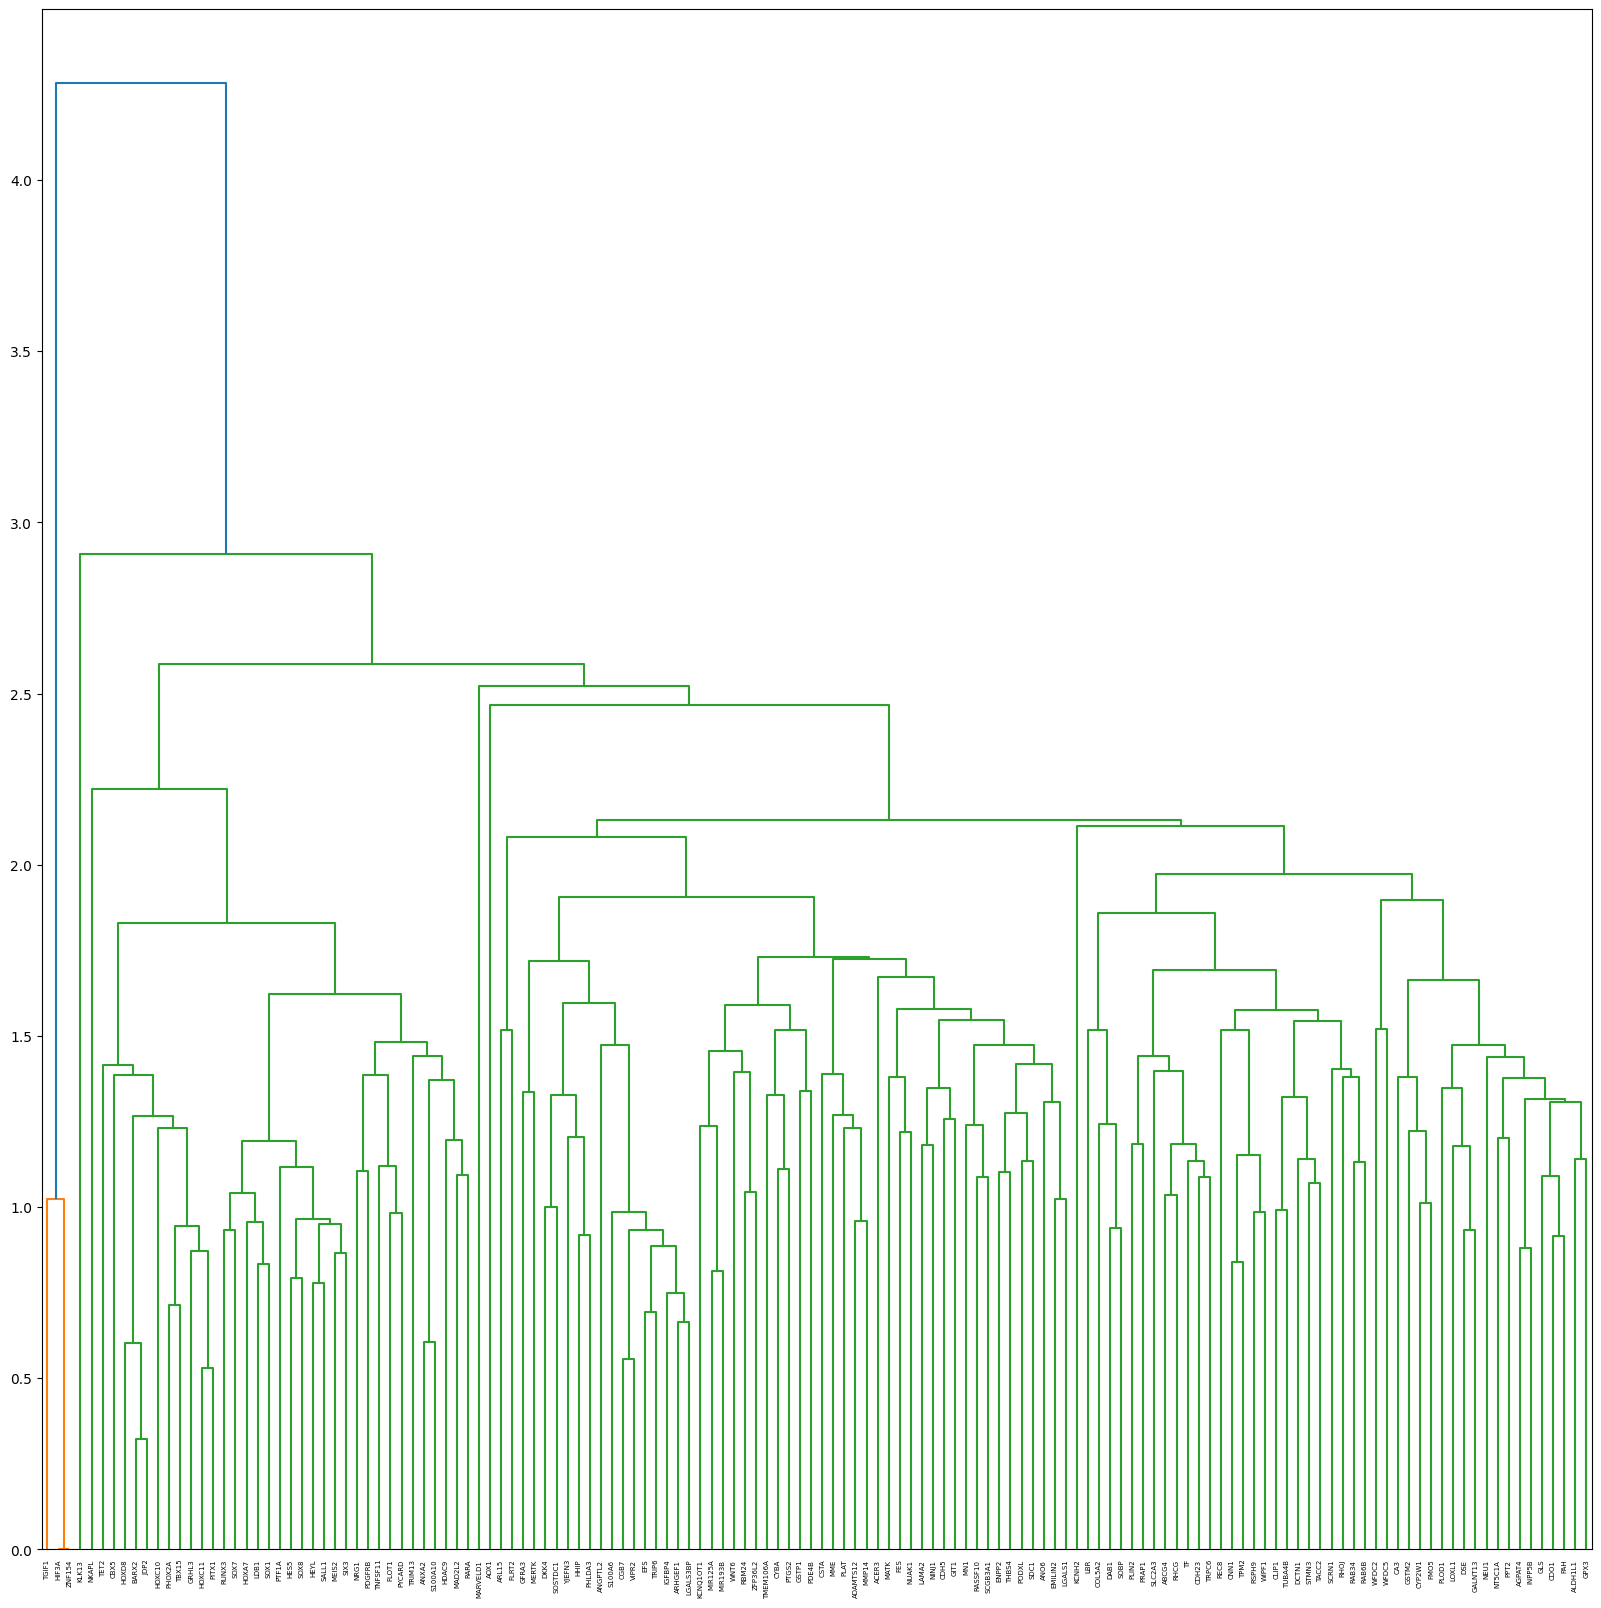

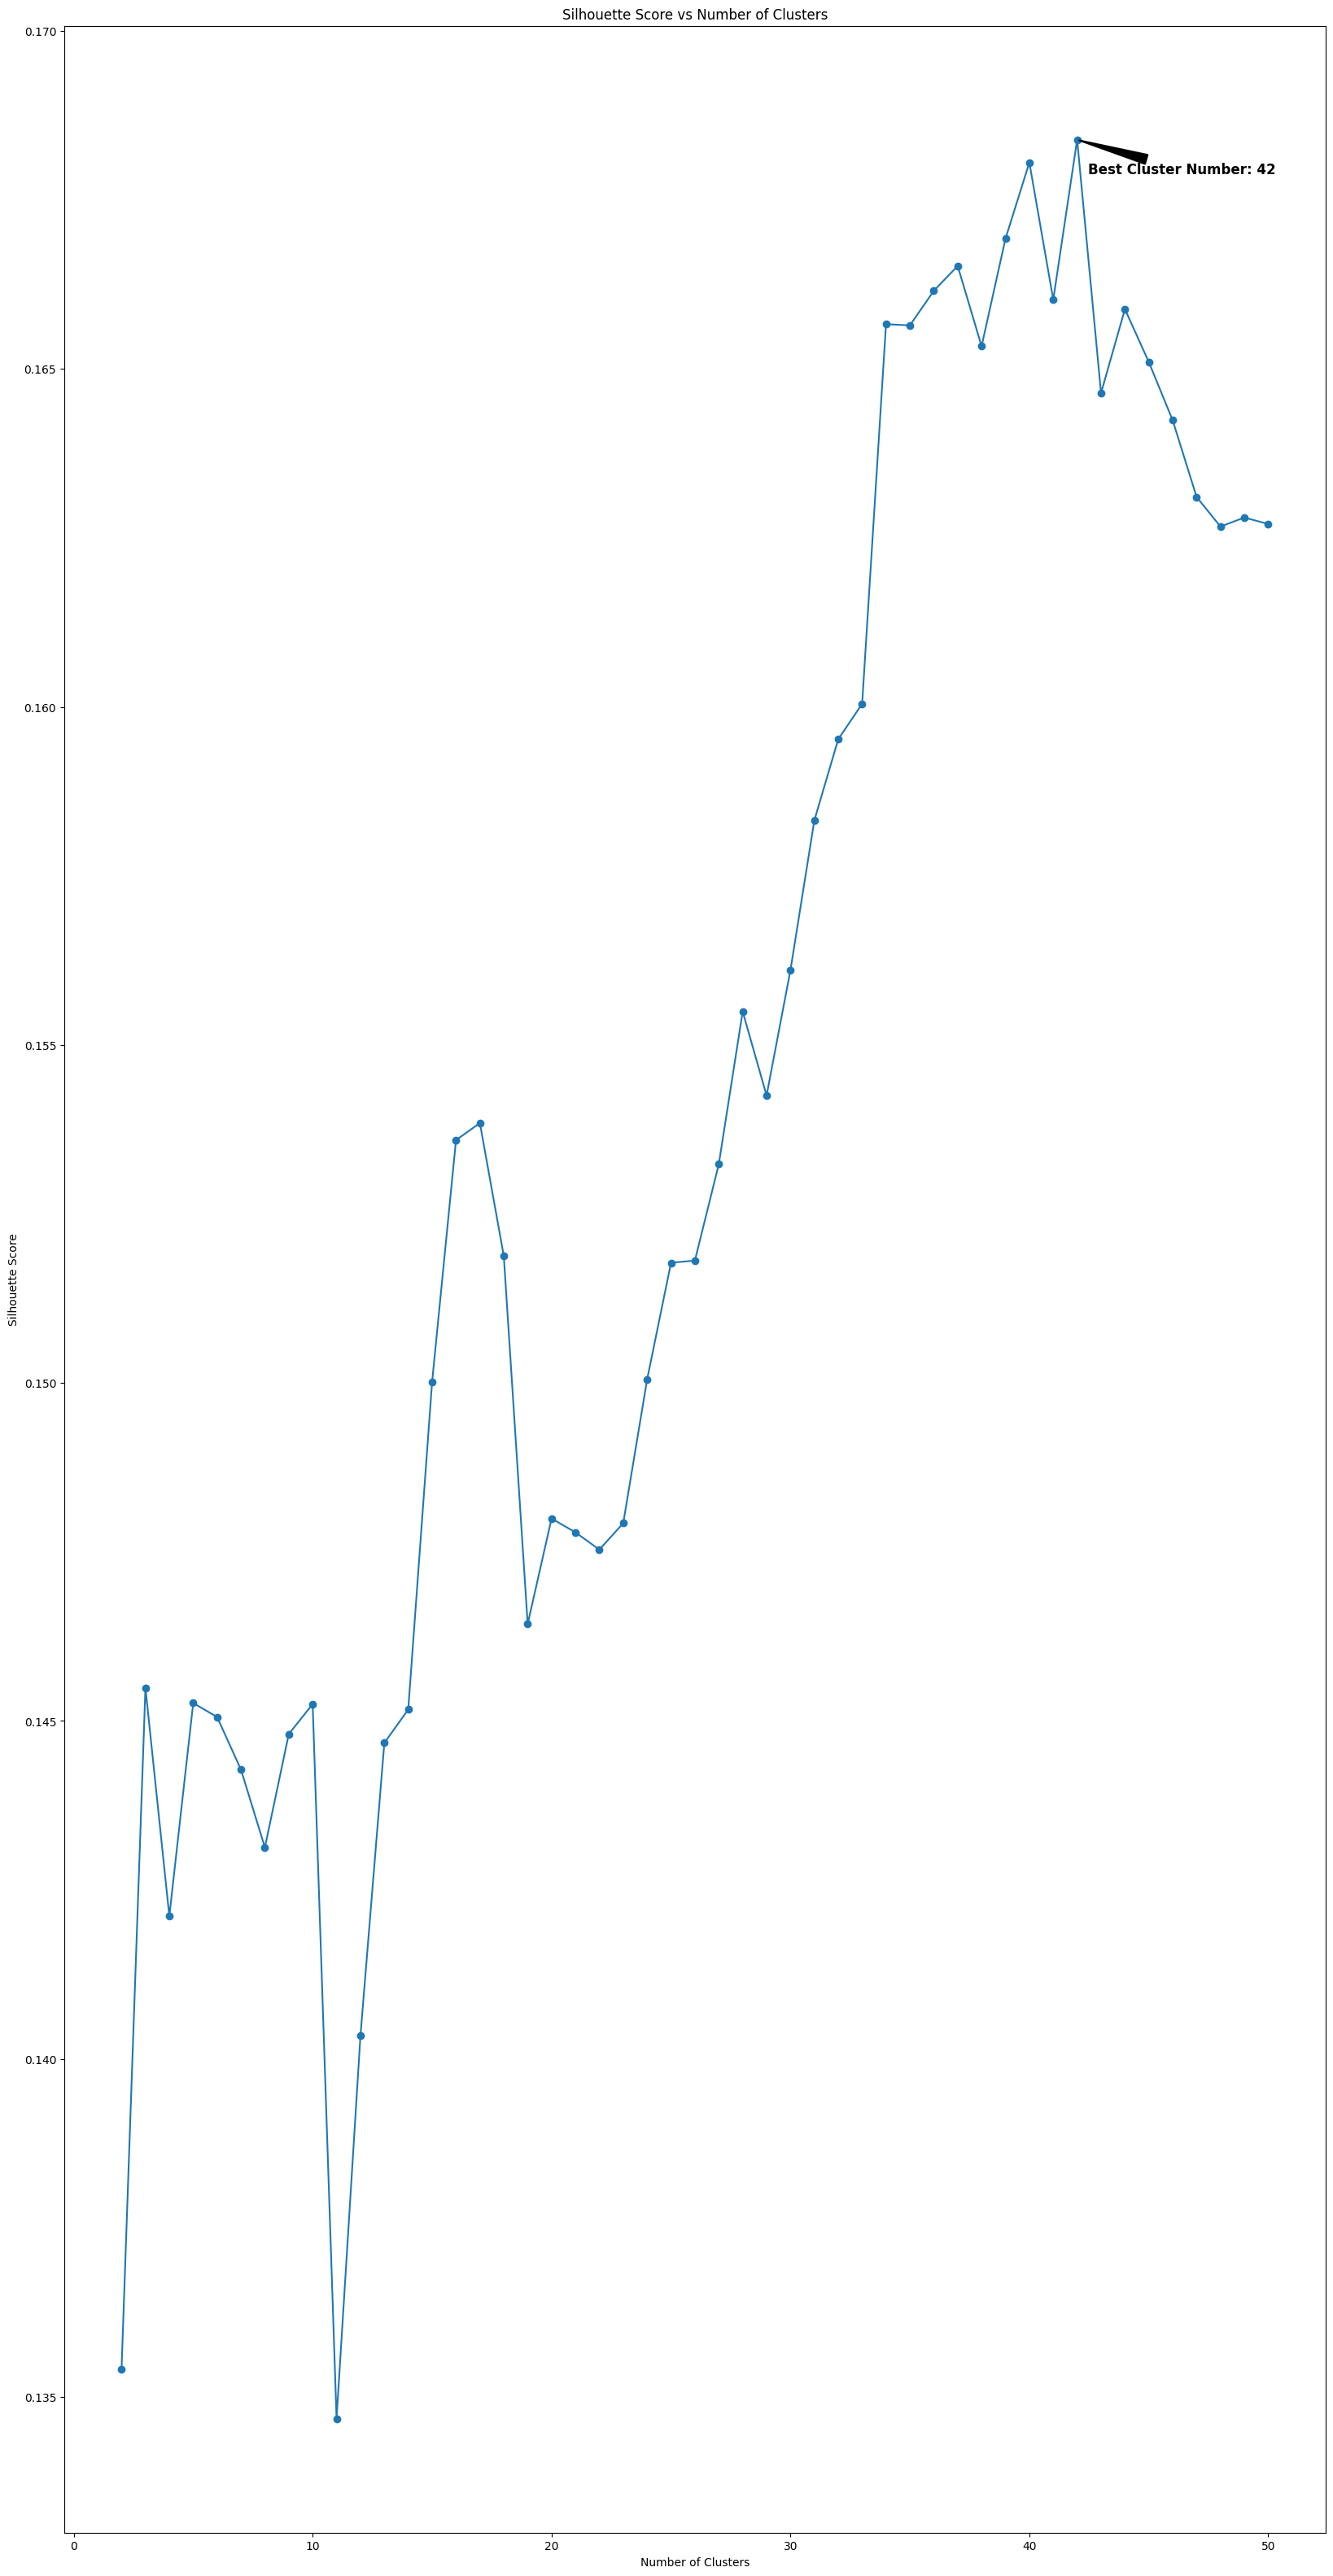

In [17]:
import matplotlib.pyplot as plt

_gosemsimCalculator = GosemsimCalculator()

# 分群
_geneCluster, silhouetteFig = _gosemsimCalculator.ClusterHierarchy(_gosemsimDf, "ward", range(2, 51))

plt.show()

# 合併資料
_geneCluster = _geneFilter.IntersectData(_aucDf, _geneCluster, "gene")

In [ ]:

# 挑選資料
idx_max_dbeta = _geneCluster.groupby('cluster')['dbeta'].idxmax()
idx_max_auc = _geneCluster.groupby('cluster')['auc'].idxmax()
idx_max_F1 = _geneCluster.groupby('cluster')['F1'].idxmax()

print("Dbeta Max:")
print(_geneCluster.loc[idx_max_dbeta])
print("AUC Max:")
print(_geneCluster.loc[idx_max_auc])
print("F1 Max:")
print(_geneCluster.loc[idx_max_F1])